# Training 

This file contains the training part of the RNN.

This cells claims the data on Kaggle thanks to the API. 

In [1]:
import csv 
import os 
import math 
import numpy as np
from datetime import datetime
dpath = 'archive/'

#Makes the time a continuous value to work with ESN.
def time_linearisation(date): 
    format_code = "%Y/%m/%d %H:%M:%S"
    dt = datetime.strptime(date, format_code)
    half_hour_index = dt.hour * 2 + (1 if dt.minute >= 30 else 0)
    hh_sin = math.sin(2 * math.pi * half_hour_index / 48)
    hh_cos = math.cos(2 * math.pi * half_hour_index / 48)

    # Week day
    dow = dt.weekday()
    dow_sin = math.sin(2 * math.pi * dow / 7)
    dow_cos = math.cos(2 * math.pi * dow / 7)

    # Month day
    dom = dt.day - 1
    days_in_month = 31  # number of days in a month approximation
    dom_sin = math.sin(2 * math.pi * dom / days_in_month)
    dom_cos = math.cos(2 * math.pi * dom / days_in_month)

    # Months
    month = dt.month - 1
    month_sin = math.sin(2 * math.pi * month / 12)
    month_cos = math.cos(2 * math.pi * month / 12)

    return np.array([
        hh_sin, hh_cos,
        dow_sin, dow_cos,
        dom_sin, dom_cos,
        month_sin, month_cos
    ])


Gathering data in differents files, some files are not included because they contained too much data and even with a parsing of it, it caused some weird behavor to the reservoir. 

In [2]:
obj=[]
#Notes Function building the data useful for the training. 
def gathering_data(csv_reader,current_size, ind ):
    here = 0   
    if current_size>1500:
        for row in csv_reader:
            if not row or row[0].startswith("R") or here%6!=0:
                continue
            data[here + ind ,0:8]= np.array(time_linearisation(row[1]))
            data[here + ind ,8]= float(row[2])
            data[here + ind ,9] = float(row[3])
            here+=1
    else :
        for row in csv_reader:
            if not row or row[0].startswith("R"):
                continue
            data[here + ind ,0:8]= np.array(time_linearisation(row[1]))
            data[here + ind ,8]= float(row[2])
            data[here + ind ,9] = float(row[3])
            here+=1
    return data

def size(repo):
    lst = os.listdir("./archive/")
    lst.sort()
    list = []
    # sorting to get data in the chronologic time. 
    for file in lst : 
        size = 0 
        with open(dpath + file, mode = 'r') as file :
            csv_reader = csv.reader(file)
            for row in csv_reader:
                if not row or row[0].startswith("R"):
                    continue
                size +=1
            list.append(size)
    return list



def correcting_size(repo): 
    lst = os.listdir("./archive/")
    lst.sort()
    current= 0 
    new_list =[]
     # sorting to get data in the chronologic time. 
    for file in lst : 
        here =0
        size = 0 
        if list[current]<1500:
            new_list.append(list[current])
            current +=1
            continue 
        else : 
            with open(dpath + file, mode = 'r') as file :
                csv_reader = csv.reader(file)
                for row in csv_reader:
                    if not row or row[0].startswith("R") or here%6!=0:
                        here +=1
                        continue
                    else:
                        here+=1
                        size  +=1
                new_list.append(size)
                current+=1
    return new_list
#Doing it with each file 
list = size(dpath)
final_list = correcting_size(dpath)
data = np.zeros((sum(final_list),10))

def gathering_all(repo):
    lst = os.listdir("./archive/")
    lst.sort()
    current = 0
    ind = 0 
    # sorting to get data in the chronologic time. 
    for file in lst : 
        with open(dpath + file, mode = 'r') as file :
            csv_reader = csv.reader(file)
            current_size = list[current]
            gathering_data(csv_reader, current_size, ind)
        ind += final_list[current]
        current +=1
        

gathering_all(dpath)


Building of the ESN

In [51]:
import matplotlib.pyplot as plt 
def plot_train_test(X_train, y_train, X_test, y_test):
    sample = 40000
    test_len = X_test.shape[0]
    fig = plt.figure(figsize=(15, 5))
    plt.plot(np.arange(0, 40000), X_train[:sample,8], label="Training data")
    plt.plot(np.arange(0, 40000), y_train[:sample,8], label="Training ground truth")
    plt.plot(np.arange(40000, 40000+test_len), X_test[:,8], label="Testing data")
    plt.plot(np.arange(40000, 40000+test_len), y_test[:,8], label="Testing ground truth")
    plt.legend()
    plt.show()

Data are taken according to calculus made in ```bash
finding_hyper.ipynb```. Yet values are not convincing, the hypothesis is because data are not normalized and this necessary in a ESN. Moreover, this is a temporal series then an online learning should be better. This is implemented in the file ```bash 
recurrent_learning.ipynb``` 

In [116]:
from reservoirpy.datasets import to_forecasting
x,y= to_forecasting(data, forecast=1)
y = y[:, 8].reshape(-1, 1) # chosing the data that will be used (electricity consuption)
units = 500 
leak_rate = 0.1
spectral_radius = 0.7
input_scaling = 1.
connectivity = 0.8
input_connectivity = 0.2
regularization = 1e-1
seed = 42
X_train1, y_train1 = x[:40000], y[:40000]
X_test1, y_test1 = x[40000:], y[40000:]
X_test1 = np.asarray(X_test1) # chosing the data that will be used (electricity consuption)
X_test1 = X_test1.reshape(X_test1.shape[0], -1) # reshaping data that they could be used by reservoir py
# plot_train_test(X_train1, y_train1, X_test1, y_test1)


Functions allowing to build and reset the ESN. 

In [108]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                          lr=leak_rate, rc_connectivity=connectivity,
                          input_connectivity=input_connectivity, seed=seed)
    readout   = Ridge(ridge=regularization, output_dim=1) #10 size of the entry vector 

    return reservoir >> readout


In [109]:
from reservoirpy.nodes import Reservoir, Ridge
reset_esn()

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = Ridge(ridge=regularization, output_dim=1)

esn = reservoir >> readout

In [110]:
esn = esn.fit(X_train1, y_train1)
def plot_results(y_pred, y_test, sample=800):

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(np.arange(sample), y_pred[:sample], lw=3, label="ESN prediction")
    plt.plot(np.arange(sample), y_test[:sample], linestyle="--", lw=2, label="True value")
    plt.plot(np.abs(y_test[:sample] - y_pred[:sample]), label="Absolute deviation")

    plt.legend()
    plt.show()

In [114]:
y_pred1 = esn.run(X_test1)

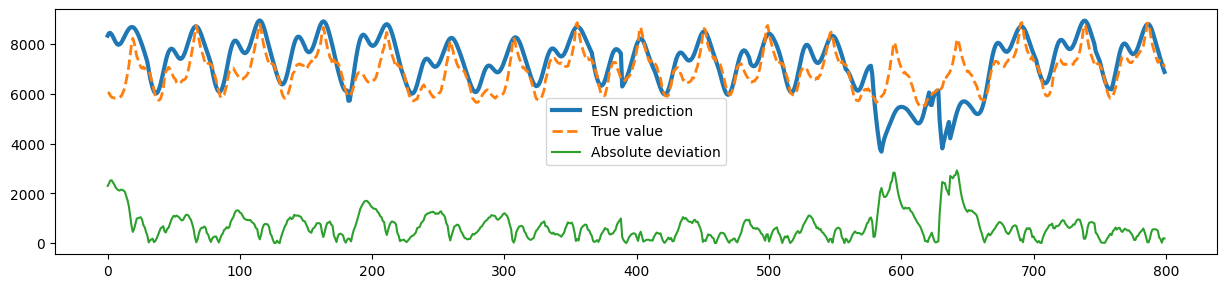

In [115]:
plot_results(y_pred1, y_test1)

# Conclusion 

The forecast is not precised, the result is closer to a mean of the situation. This is possibly caused by the extreme values in some cases. 
At the beginning, the system seems to smoothen values then values are exagerates and system struggles to follow peaks. Even though with an increased number of neurons, this is not improving the situation and reach an overfitting situation. It looks like the network is approaching  the best periodic function than folowing real values. So, this periods according to our dataset could be seen as days in the current case.  